In [38]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torchvision

In [2]:

!pip install kaggle

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace 'username/dataset_name' with the actual Kaggle dataset path
!kaggle datasets download -d crawford/cat-dataset

# Unzip the downloaded dataset (if necessary)
!unzip /content/cat-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset
License(s): CC0-1.0
100% 4.02G/4.04G [00:26<00:00, 118MB/s]
100% 4.04G/4.04G [00:26<00:00, 161MB/s]


In [35]:

# Define the dataset
class CatDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None, max_samples=10):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_files = glob.glob(os.path.join(dataset_dir, "*.jpg"))[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = self.image_files[index]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Generate dummy annotations
        annotations = torch.randn(9)

        return image, annotations

# Define the generator and discriminator networks
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z).view(-1, 3, 64, 64)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Training loop
def train_gan(dataloader, generator, discriminator, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        for i, (real_images, _) in enumerate(dataloader):
            # Train the discriminator
            real_images = real_images.to(device)
            real_labels = torch.ones(real_images.size(0), device=device)
            d_optimizer.zero_grad()
            d_real_output = discriminator(real_images)
            d_real_loss = criterion(d_real_output, real_labels)

            z = torch.randn(real_images.size(0), 100, device=device)
            fake_images = generator(z)
            fake_labels = torch.zeros(real_images.size(0), device=device)
            d_fake_output = discriminator(fake_images.detach())
            d_fake_loss = criterion(d_fake_output, fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train the generator
            g_optimizer.zero_grad()
            z = torch.randn(real_images.size(0), 100, device=device)
            fake_images = generator(z)
            g_output = discriminator(fake_images)
            g_loss = criterion(g_output, real_labels)
            g_loss.backward()
            g_optimizer.step()

            train_loss += d_loss.item() + g_loss.item()

        # Evaluate on validation set
        with torch.no_grad():
            for val_images, _ in val_loader:
                val_images = val_images.to(device)
                val_labels = torch.ones(val_images.size(0), device=device)
                d_val_output = discriminator(val_images)
                val_d_loss = criterion(d_val_output, val_labels)

                z = torch.randn(val_images.size(0), 100, device=device)
                val_fake_images = generator(z)
                val_g_output = discriminator(val_fake_images)
                val_g_loss = criterion(val_g_output, val_labels)
                val_loss += val_d_loss.item() + val_g_loss.item()

        train_loss /= len(dataloader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot the training and validation loss convergence graphs
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Convergence')
    plt.legend()
    plt.savefig('loss_convergence.png')

    return generator, discriminator

In [43]:
INPUT_PATH = "/content/CAT_01"
dataset = CatDataset(INPUT_PATH, transform=transforms.Compose([Resize((64, 64)), ToTensor()]), max_samples=100)

In [44]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [45]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [46]:
generator = Generator()
discriminator = Discriminator()

Using device: cpu
Epoch [10/100], Train Loss: 14.5818, Val Loss: 11.7181
Epoch [20/100], Train Loss: 7.9021, Val Loss: 5.2557
Epoch [30/100], Train Loss: 7.4949, Val Loss: 3.7950
Epoch [40/100], Train Loss: 7.4937, Val Loss: 3.7933
Epoch [50/100], Train Loss: 7.4306, Val Loss: 4.4406
Epoch [60/100], Train Loss: 7.3871, Val Loss: 4.5946
Epoch [70/100], Train Loss: 35.9669, Val Loss: 33.6583
Epoch [80/100], Train Loss: 9.8893, Val Loss: 5.2884
Epoch [90/100], Train Loss: 5.8908, Val Loss: 2.9012
Epoch [100/100], Train Loss: 5.5155, Val Loss: 0.1606


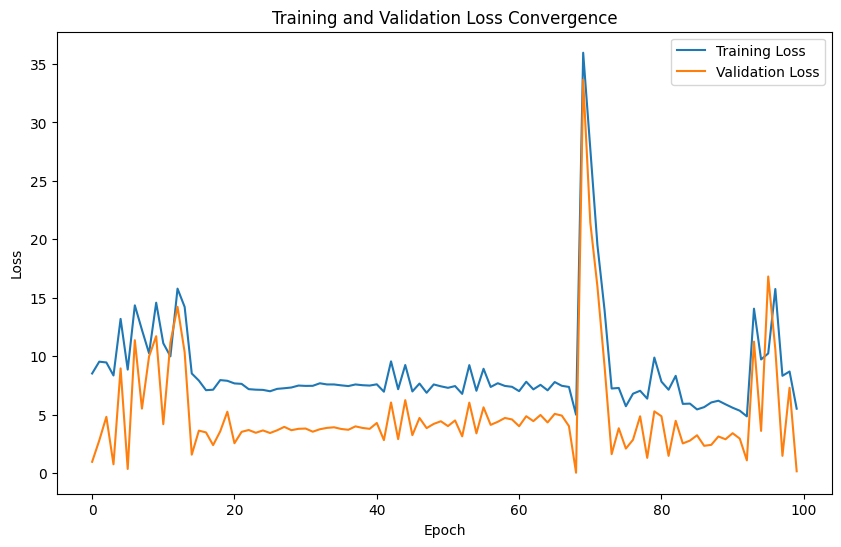

In [47]:
# Train the model on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator, discriminator = train_gan(train_loader, generator, discriminator)

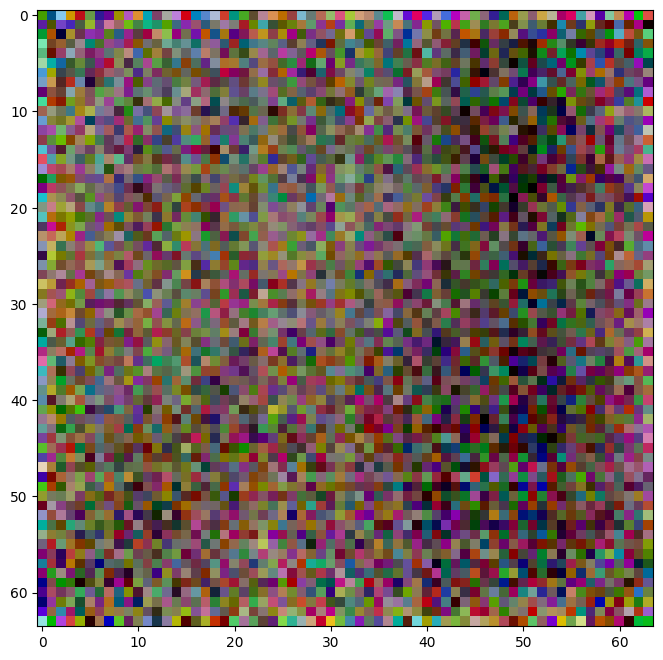

In [48]:
z = torch.randn(1, 100, device=device)
generated_image = generator(z)
grid = torchvision.utils.make_grid(generated_image.detach(), nrow=1)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.savefig("generated_cat.png")